<a href="https://colab.research.google.com/github/meliksahb/Design-of-Intelligent-Machines-ME536-/blob/main/CharacterDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define characters and font
CHARZ = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
FONT_PATH = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
IMG_SIZE = 30  # Cell size
fR = 0.8
nB = int(IMG_SIZE*(1-fR))
# Generate synthetic data
def create_training_data(font_path, charz, img_size=30, num_samples_per_char=1000):
    training_data = []
    labels = []
    for idx, char in enumerate(charz):
        for _ in range(num_samples_per_char):
            # Create an image with a single character
            img = Image.new('RGB', (img_size, img_size), (255, 255, 255))
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype(font_path, size=np.random.randint(12, IMG_SIZE-1))
            x_offset = int(np.random.rand()* nB)
            y_offset = int(np.random.rand()* nB)
            draw.text((x_offset, y_offset), char, font=font, fill=(0, 0, 0))

            # Convert to grayscale and normalize
            img_array = np.array(img.convert('L'))
            training_data.append(img_array)
            labels.append(idx)

    training_data = np.array(training_data).reshape(-1, img_size, img_size, 1) / 255.0
    labels = np.array(labels)
    return training_data, labels

# Generate training data
X, y = create_training_data(FONT_PATH, CHARZ)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the CNN
def build_cnn(input_shape=(30, 30, 1), num_classes=len(CHARZ)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the CNN
model = build_cnn()

# Train the CNN
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# # Display training history
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Save the model
model.save('character_recognition_model.h5')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4616 - loss: 1.5252 - val_accuracy: 0.9900 - val_loss: 0.1067
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9932 - loss: 0.0662 - val_accuracy: 1.0000 - val_loss: 0.0207
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9998 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 7.4793e-04 - val_accuracy: 1.0000 - val_loss: 8.9590e-04
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 1.0000 - loss: 5.7021e-04 - val_

Test Accuracy: 1.00


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from PIL import ImageColor


# Define character set and colors
CHARZ = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
CHAR_COLORS = {
    'B': "pink", 'U': "yellow", 'D': "green", 'R': "orange",
    'K': "red", 'A': "cyan", 'E': "magenta", '6': "blue", 'N': "purple"
}
FONT_PATH = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"  # Adjust as needed

# Load the saved CNN model
model = load_model('/content/character_recognition_model.h5')



# Function to preprocess test image and extract cells
def preprocess_gen_image(img, cell_size=30):
    """
    Preprocess the generated image to extract cells and their locations.
    """
    img_array = np.array(img)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    cells = []
    locations = []
    for y in range(0, img_array.shape[0], cell_size):
        for x in range(0, img_array.shape[1], cell_size):
            cell = gray[y:y+cell_size, x:x+cell_size]
            if np.sum(cell < 255) > 10:  # Check for non-white pixels
                cells.append(cell)
                locations.append((x, y))
    cells = np.array(cells).reshape(-1, cell_size, cell_size, 1) / 255.0
    return cells, locations


# Function to annotate and display results
def annotate_image(img, locations, predictions, char_locations, cell_size=30):
    """
    Annotate the image with predicted characters and colors.
    """
    draw = ImageDraw.Draw(img)

    img_array = np.array(img)
    for (x, y), pred_idx in zip(locations, predictions):
        char = CHARZ[pred_idx]
        color = CHAR_COLORS[char]
        # Color the rectangle without overwriting the character
        draw.rectangle([x, y, x + cell_size, y + cell_size], outline=color, width=2)

        # Convert color name to RGB
        rgb_color = ImageColor.getrgb(color)

       # Extract the region of interest (ROI) for the character
        roi = img.crop((x, y, x + cell_size, y + cell_size))

        # Convert the ROI to a numpy array for processing
        roi_array = np.array(roi)

        # Identify the pixels that belong to the character (non-white pixels)
        mask = np.all(roi_array < [200, 200, 200], axis=-1)  # Adjust threshold as needed

        # Apply the color to the detected character
        roi_array[mask] = rgb_color  # Apply the color to the detected character

        # Convert back to an image and paste it back into the original image
        img.paste(Image.fromarray(roi_array), (x, y))

        # Store the character's location
        char_locations[char].append((x + cell_size / 2, y + cell_size / 2))

# # Function to test the CNN on saved images
# def test_saved_images(image_array, output_folder):

#     char_locations = {char: [] for char in CHARZ}

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
#     image = np.load(image_array)
#     img = Image.fromarray(image.astype('uint8'))
#     cells, locations = preprocess_gen_image(img)

#     # Predict characters using the CNN
#     predictions = np.argmax(model.predict(cells), axis=1)

#     annotate_image(img, locations, predictions, char_locations)

#     # Save the annotated image
#     output_path = os.path.join(output_folder, "annotated_image.png")
#     img.save(output_path)
#     print(f"Processed and saved: {output_path}")

#     return char_locations, img

    # for img_path in image_paths:
          # char_locations = {char: [] for char in CHARZ}

    #     # Load the test image
    #     img = np.load(img_path)
    #     img = Image.fromarray(img.astype('uint8'))  # Convert to PIL Image

    #     # Preprocess the image to extract cells and their locations
    #     cells, locations = preprocess_gen_image(img)

    #     # Predict characters using the CNN
    #     predictions = np.argmax(model.predict(cells), axis=1)

    #     annotate_image(img, locations, predictions, char_locations)

    #     # Save the annotated image
    #     output_path = os.path.join(output_folder, os.path.basename(img_path).replace('.npy', '_annotated.png'))
    #     img.save(output_path)
    #     print(f"Processed and saved: {output_path}")
    #     # print(len(char_locations['K']))
    #     return char_locations, annotate_image

# # Paths to test images
# image_folder = '/content/'
# image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.npy')]

# # Output folder for annotated images
# output_folder = "/content/"

# # # Test on the saved images
# # test_saved_images(image_paths, output_folder)

# img = '/content/simpleF.npy'
# test_saved_images(img, output_folder)


In [ ]:
import math
def distance(p1, p2):
    return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

def rotate90CW(x, y):
    """
    Rotate the vector (x, y) by +90 degrees (clockwise).
    Result: (y, -x).
    """
    return (y, -x)

def rotate90CCW(x, y):
    """
    Rotate the vector (x, y) by -90 degrees (counter-clockwise).
    Result: (-y, x).
    """
    return (-y, x)

def vector(p1, p2):
    """2D vector from p1 to p2."""
    return (p2[0] - p1[0], p2[1] - p1[1])

def dot_product(v1, v2):
    """Dot product of two 2D vectors."""
    return v1[0]*v2[0] + v1[1]*v2[1]

def is_perpendicular(p1, p2, p3, tol=1e-5):
    """
    Check if the angle at p2 (formed by p2->p1 and p2->p3) is ~90 degrees.
    """
    v1 = vector(p2, p1)
    v2 = vector(p2, p3)
    return abs(dot_product(v1, v2)) < tol

def is_square(kpt, apt, rpt, ept, dist_tol=1e-5, angle_tol=1e-5):
    """
    Checks if points (K, A, R, E) form a square in order K->A->R->E->K.
    1) All sides ~ equal
    2) All angles ~ 90 degrees
    """
    dKA = distance(kpt, apt)
    dAR = distance(apt, rpt)
    dRE = distance(rpt, ept)
    dEK = distance(ept, kpt)

    sides = [dKA, dAR, dRE, dEK]
    mean_side = sum(sides) / 4.0

    # Check side lengths
    for s in sides:
        if abs(s - mean_side) > dist_tol:
            return False

    # Check angles at A, R, E, K
    if (not is_perpendicular(kpt, apt, rpt, angle_tol) or
        not is_perpendicular(apt, rpt, ept, angle_tol) or
        not is_perpendicular(rpt, ept, kpt, angle_tol) or
        not is_perpendicular(ept, kpt, apt, angle_tol)):
        return False

    return True

def find_neighbors(letter_points, est_point, max_dist=3.0):
    """
    Return all points in `letter_points` that are within `max_dist` of `est_point`.
    """
    candidates = []
    for p in letter_points:
        if distance(p, est_point) <= max_dist:
            candidates.append(p)
    return candidates

def find_best_square(k_points, a_points, r_points, e_points,
                     dist_tol=1e-5, angle_tol=1e-5):
    """
    Search all combos of K, A, R, E points, return the "best" square
    (largest side). If none found, returns None.
    """
    best_square_pts = None
    best_side_len = 0.0

    for kpt in k_points:
        for apt in a_points:
            for rpt in r_points:
                for ept in e_points:
                    if is_square(kpt, apt, rpt, ept, dist_tol, angle_tol):
                        # Use distance(K, A) as side length
                        side_len = distance(kpt, apt)
                        if side_len > best_side_len:
                            best_side_len = side_len
                            best_square_pts = (kpt, apt, rpt, ept)

    return best_square_pts

def find_all_squares_kare_optimized(k_points, a_points, r_points, e_points,
                                    dist_tol=1e-5, angle_tol=1e-5,
                                    corner_tol=3.0):
    """
    Return a list of *all* squares (K, A, R, E) that form a valid K->A->R->E->K
    using the geometry approach:
      - For each (K, A), compute the two possible corners R_est, E_est by rotating KA
        +90° or -90° around A, and similarly around K.
      - Find actual R in r_points near R_est, actual E in e_points near E_est.
      - For each candidate, do a final is_square(...) check.
    corner_tol = max distance in pixels to consider a point "matching" the computed corner.
    """
    squares_found = []

    for kpt in k_points:
        for apt in a_points:
            # Vector K->A
            vx = apt[0] - kpt[0]
            vy = apt[1] - kpt[1]
            if abs(vx) < 1e-7 and abs(vy) < 1e-7:
                # kpt == apt? skip
                continue

            # 1) CW orientation: rotate (K->A) by +90 deg around A => A->R
            #    Also rotate (K->A) by +90 deg around K => K->E
            #    Then R_est = A + rotate90CW(K->A)
            #         E_est = K + rotate90CW(K->A)
            vx_cw, vy_cw = rotate90CW(vx, vy)
            r_est_cw = (apt[0] + vx_cw, apt[1] + vy_cw)
            e_est_cw = (kpt[0] + vx_cw, kpt[1] + vy_cw)

            # 2) CCW orientation: rotate (K->A) by -90 deg around A => A->R
            #                     rotate (K->A) by -90 deg around K => K->E
            vx_ccw, vy_ccw = rotate90CCW(vx, vy)
            r_est_ccw = (apt[0] + vx_ccw, apt[1] + vy_ccw)
            e_est_ccw = (kpt[0] + vx_ccw, kpt[1] + vy_ccw)

            # Now find actual R points near r_est_cw, E points near e_est_cw, etc.
            # We'll do for BOTH cw and ccw:
            #    For each r in neighbors..., e in neighbors..., check is_square(k,a,r,e).

            # Check CW
            r_candidates_cw = find_neighbors(r_points, r_est_cw, corner_tol)
            e_candidates_cw = find_neighbors(e_points, e_est_cw, corner_tol)
            for rpt in r_candidates_cw:
                for ept in e_candidates_cw:
                    if is_square(kpt, apt, rpt, ept, dist_tol, angle_tol):
                        squares_found.append((kpt, apt, rpt, ept))

            # Check CCW
            r_candidates_ccw = find_neighbors(r_points, r_est_ccw, corner_tol)
            e_candidates_ccw = find_neighbors(e_points, e_est_ccw, corner_tol)
            for rpt in r_candidates_ccw:
                for ept in e_candidates_ccw:
                    if is_square(kpt, apt, rpt, ept, dist_tol, angle_tol):
                        squares_found.append((kpt, apt, rpt, ept))

    return squares_found

def draw_squares_pil(pil_image, squares, color='lime', width=3):
    """
    squares is a list of (K, A, R, E) points.
    Draw each square in order K->A->R->E->K.
    """
    draw = ImageDraw.Draw(pil_image)
    for (kpt, apt, rpt, ept) in squares:
        kpt_i = (int(kpt[0]), int(kpt[1]))
        apt_i = (int(apt[0]), int(apt[1]))
        rpt_i = (int(rpt[0]), int(rpt[1]))
        ept_i = (int(ept[0]), int(ept[1]))

        draw.line([kpt_i, apt_i], fill=color, width=width)
        draw.line([apt_i, rpt_i], fill=color, width=width)
        draw.line([rpt_i, ept_i], fill=color, width=width)
        draw.line([ept_i, kpt_i], fill=color, width=width)

def build_letter_grid(height, width, cell_size, recognized_letters):
    """
    Build a 2D array 'grid' of shape (rows, cols), where each element is
    the recognized letter (like 'B','U','D','R', etc.) or '' if none.
    - height, width: total pixel dimensions of the puzzle
    - cell_size: e.g. 30
    - recognized_letters: list of (letter, row, col) or dict structure
      row, col are the grid coords, i.e. row = y//cell_size, col = x//cell_size
    Returns: grid (list of lists), with shape = (rows, cols)
    """
    rows = height // cell_size
    cols = width // cell_size
    grid = [['' for _ in range(cols)] for _ in range(rows)]

    # recognized_letters might be something like:
    # [ ('B', 0, 3), ('U', 0,4), ('D', 1,4), ... ]
    # meaning row=0,col=3 has 'B', etc.
    for (letter, r, c) in recognized_letters:
        if 0 <= r < rows and 0 <= c < cols:
            grid[r][c] = letter

    return grid

from collections import deque

# 8 directions: N, NE, E, SE, S, SW, W, NW
DIRS_8 = [(-1, 0), (-1, 1), (0, 1), (1, 1),
          (1, 0), (1, -1), (0, -1), (-1, -1)]
def pop_best(open_list):
    """
    Remove and return the (f, g, state) item with the smallest f.
    O(n) scan each time.
    """
    best_idx = 0
    best_f, _, _ = open_list[0]
    for i, (f_val, g_val, st) in enumerate(open_list):
        if f_val < best_f:
            best_f = f_val
            best_idx = i
    return open_list.pop(best_idx)

def reconstruct_path(state, parent):
    """
    Reconstruct path of (r,c) from the final state => start, then reverse.
    state = (r,c,i,u1r,u1c).
    """
    path = []
    cur = state
    while cur in parent:
        (r, c, i, u1r, u1c) = cur
        path.append((r, c))
        cur = parent[cur]
    # add the very first state's cell
    (r0, c0, i0, ur0, uc0) = cur
    path.append((r0, c0))
    path.reverse()
    return path

def a_star_budur_nheap(grid):
    """
    Find a path that spells 'BUDUR' in an open grid with 8 directions,
    but do not use heapq. We'll keep an open_list (list) and pop the best f manually.

    grid[r][c] = letter or ''
    Returns (cost, path), or (inf, None).
    """

    rows = len(grid)
    cols = len(grid[0]) if rows>0 else 0
    word = ['B','U','D','U','R']

    # We'll define a trivial heuristic = 0.
    # If you have distance maps, you can do: h(...) = dist_letter[next_needed][r][c].
    def heuristic(r, c, i, u1r, u1c):
        return 0  # no real heuristic => effectively D' search

    # best_cost dict: best_cost[(r,c,i,u1r,u1c)] = minimal cost discovered
    best_cost = {}
    parent = {}

    # Initialize the open list with all cells that contain 'B'
    open_list = []
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 'B':
                # we've matched the first letter B => i=1
                state = (r, c, 1, -1, -1)
                g0 = 0
                f0 = g0 + heuristic(r,c,1,-1,-1)
                best_cost[state] = g0
                open_list.append((f0, g0, state))

    if not open_list:
        return (math.inf, None)  # no 'B' in the grid

    while open_list:
        # pop the item with smallest f
        f, g, (r, c, i, u1r, u1c) = pop_best(open_list)

        # if we've already found a better cost, skip this
        if best_cost.get((r,c,i,u1r,u1c), math.inf) < g:
            continue

        # if i=5 => we matched all letters B(0)->U(1)->D(2)->U(3)->R(4)
        if i == 5:
            # reconstruct path
            return (g, reconstruct_path((r,c,i,u1r,u1c), parent))

        # expand neighbors
        for (dr, dc) in DIRS_8:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols:
                cost_next = g + 1
                next_i = i
                next_u1r, next_u1c = (u1r, u1c)
                # check if we can match the next letter
                if i < len(word):
                    needed = word[i]
                    cell_letter = grid[nr][nc]
                    if cell_letter == needed:
                        # match => i -> i+1
                        next_i = i + 1
                        if i == 1:
                            # we just matched the first 'U'
                            next_u1r, next_u1c = (nr, nc)
                        if i == 3:
                            # second 'U' => must differ from first
                            if (nr, nc) == (u1r, u1c):
                                continue  # can't reuse the same U

                nxt_state = (nr, nc, next_i, next_u1r, next_u1c)
                old_cost = best_cost.get(nxt_state, math.inf)
                if cost_next < old_cost:
                    best_cost[nxt_state] = cost_next
                    parent[nxt_state] = (r, c, i, u1r, u1c)
                    f_val = cost_next + heuristic(nr, nc, next_i, next_u1r, next_u1c)
                    open_list.append((f_val, cost_next, nxt_state))

    return (math.inf, None)

def build_all_dist_maps(grid):
    """
    Build dist_letter['B'], dist_letter['U'], dist_letter['D'], dist_letter['R']
    for the puzzle.
    Return a dict: dist_letter[char] = 2D array of distances.
    """
    letters_needed = ['B','U','D','R']  # for "BUDUR"
    dist_letter = {}
    for letter in letters_needed:
        dist_letter[letter] = build_dist_map_for_letter(grid, letter)
    return dist_letter

def bfs_8dir(grid, start_r, start_c, target_letter):
    """
    BFS from (start_r, start_c) to find the nearest cell that has `target_letter`.
    grid[r][c] is the letter in that cell or '' if none.
    Returns (distance, path) if found, else (inf, None).

    path is a list of (row, col) from start to target (inclusive).
    """
    rows = len(grid)
    cols = len(grid[0]) if rows > 0 else 0

    # If the start cell itself has the target letter, path = [start].
    if grid[start_r][start_c] == target_letter:
        return (0, [(start_r, start_c)])

    visited = [[False]*cols for _ in range(rows)]
    visited[start_r][start_c] = True
    parent = dict()  # to reconstruct path: parent[(r,c)] = (pr, pc)

    queue = deque()
    queue.append((start_r, start_c, 0))  # (row, col, distance)

    while queue:
        r, c, dist = queue.popleft()
        # explore neighbors
        for dr, dc in DIRS_8:
            nr = r + dr
            nc = c + dc
            if 0 <= nr < rows and 0 <= nc < cols and not visited[nr][nc]:
                visited[nr][nc] = True
                parent[(nr, nc)] = (r, c)  # store how we reached (nr, nc)
                # check if we've found the target
                if grid[nr][nc] == target_letter:
                    # reconstruct path
                    path = [(nr, nc)]
                    # backtrack
                    cur = (nr, nc)
                    while cur != (start_r, start_c):
                        cur = parent[cur]
                        path.append(cur)
                    path.reverse()
                    return (dist+1, path)
                # else continue BFS
                queue.append((nr, nc, dist+1))

    return (float('inf'), None)  # not found

def find_shortest_path_BUDUR_8dir(grid):
    """
    Find the global shortest path that spells B->U->D->U->R in 8 directions.
    Return (dist, full_path) if found, else (inf, None).

    full_path is a list of (row, col).
    """
    rows = len(grid)
    cols = len(grid[0]) if rows>0 else 0

    # 1) Collect all B positions
    b_positions = []
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 'B':
                b_positions.append((r, c))

    # If no B, no path
    if not b_positions:
        return (float('inf'), None)

    best_dist = float('inf')
    best_path = None

    # For each B, do BFS to find first U
    for (br, bc) in b_positions:
        distBU, pathBU = bfs_8dir(grid, br, bc, 'U')
        if distBU == float('inf'):
            continue  # can't find U from this B

        # Now from that U, BFS to D
        ur1, uc1 = pathBU[-1]  # the U we arrived at
        distUD, pathUD = bfs_8dir(grid, ur1, uc1, 'D')
        if distUD == float('inf'):
            continue  # no D from this U

        # From that D, BFS to a *different* U
        dr, dc = pathUD[-1]
        # We'll do a BFS for 'U', but if we land on the same (ur1, uc1), skip.
        distU2, pathU2 = bfs_8dir(grid, dr, dc, 'U')
        if distU2 == float('inf'):
            continue

        # Check if that U is different from the first U
        ur2, uc2 = pathU2[-1]
        if (ur2, uc2) == (ur1, uc1):
            # We ended up on the same U, not allowed.
            # (We can continue BFS until we find a different U,
            #  but we'd have to modify bfs_8dir for that.)
            continue

        # Finally from that second U, BFS to R
        distUR, pathUR = bfs_8dir(grid, ur2, uc2, 'R')
        if distUR == float('inf'):
            continue

        # Combine all subpaths: B->U, U->D, D->U2, U2->R
        total_dist = distBU + distUD + distU2 + distUR
        if total_dist < best_dist:
            best_dist = total_dist
            # Build the full path by merging them carefully (avoiding duplication
            # of the junction points)
            # pathBU: B...U
            # pathUD: U...D
            # pathU2: D...U2
            # pathUR: U2...R
            full_path = (pathBU[:-1] +
                         pathUD[:-1] +
                         pathU2[:-1] +
                         pathUR)
            best_path = full_path

    return (best_dist, best_path)

def draw_grid_path(pil_img, path, color='blue', width=3, cell_size=30):
    """
    path is list of (row, col). We'll draw lines from each step to the next.
    The center of (r,c) is (c*cell_size+cell_size/2, r*cell_size+cell_size/2).
    """
    if not path or len(path) < 2:
        return
    draw = ImageDraw.Draw(pil_img)
    pts = []
    for (r, c) in path:
        x = c*cell_size + cell_size/2
        y = r*cell_size + cell_size/2
        pts.append((x, y))

    for i in range(len(pts)-1):
        draw.line([pts[i], pts[i+1]], fill=color, width=width)


def dummy_build_grid(pil_img, cell_size=30):
    """
    A placeholder if you don't have the real 'build_grid_from_cnn'.
    Here we just build a small example or something.
    """
    # Convert to numpy
    arr = np.array(pil_img)
    h, w = arr.shape[:2]

    rows = h // cell_size
    cols = w // cell_size
    grid = [['' for _ in range(cols)] for _ in range(rows)]
    # E.g. fill some letters for testing
    # In reality, you'd run your CNN on each cell.
    return grid

def draw_path_pil(pil_image, path, color='blue', width=3):
    """
    path is a list of (row, col) in grid coords.
    We'll convert them to pixel coords if needed.
    """
    if not path or len(path) < 2:
        return

    draw = ImageDraw.Draw(pil_image)

    # Suppose each cell is cell_size x cell_size
    # so the center of (row, col) is (col*cell_size + cell_size/2, row*cell_size + cell_size/2).
    cell_size = 30
    pix_pts = []
    for (r, c) in path:
        px = c*cell_size + cell_size/2
        py = r*cell_size + cell_size/2
        pix_pts.append((px, py))

    # Draw lines from pix_pts[0]->pix_pts[1]->...
    for i in range(len(pix_pts)-1):
        draw.line([pix_pts[i], pix_pts[i+1]], fill=color, width=width)
def build_grid_from_cnn(pil_img, model, cell_size=30):
    """
    Given:
      - pil_img: a PIL image of your puzzle (already loaded).
      - model: your trained Keras model for character recognition.
      - cell_size: size of each grid cell in pixels (e.g. 30).

    Returns:
      - grid (list of lists) of shape [rows][cols],
        where grid[r][c] is the predicted character ('B','U','D','R','K','A','E','6','N', or '')
        if no valid character is detected.

    Notes:
      - This function assumes each grid cell has *at most* one character.
      - If you allow multiple chars per cell, you'll need a different approach.
      - You can adapt the "blank cell" threshold as needed.
    """
    import cv2
    import numpy as np
    from PIL import Image

    # 1) Convert the PIL image to a NumPy array
    img_array = np.array(pil_img)
    height, width = img_array.shape[:2]

    # 2) We'll build a 2D grid of size (rows, cols)
    rows = height // cell_size
    cols = width // cell_size

    # The recognized characters (the same order used in your CNN training)
    CHARZ = ['B','U','D','R','K','A','E','6','N']

    # Create an empty grid filled with ''
    grid = [['' for _ in range(cols)] for _ in range(rows)]

    # Convert image to grayscale for CNN input
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    # 3) Iterate over each grid cell
    for r in range(rows):
        for c in range(cols):
            # Pixel coords for this cell
            y_start = r * cell_size
            y_end   = y_start + cell_size
            x_start = c * cell_size
            x_end   = x_start + cell_size

            # Extract the cell region
            cell_gray = gray[y_start:y_end, x_start:x_end]

            # Quick check if there's something in this cell
            # (non-white area > some threshold)
            if np.sum(cell_gray < 255) < 10:
                # It's basically blank => store '' (empty)
                grid[r][c] = ''
                continue

            # 4) Prepare the cell for CNN prediction
            #    - reshape to (1, cell_size, cell_size, 1)
            cell_norm = cell_gray.reshape(1, cell_size, cell_size, 1) / 255.0

            # 5) Run the model to get prediction
            pred = model.predict(cell_norm)  # shape (1, num_classes)
            pred_idx = np.argmax(pred)       # which class index
            predicted_char = CHARZ[pred_idx]

            # 6) Store the predicted character in the grid
            grid[r][c] = predicted_char

    return grid

In [ ]:
def SearchInAlphabetSoup(img, txt='KARE'):
    """
    Given an image (numpy array) and a text (default 'KARE'),
    - If txt == 'KARE', attempt to find centers of K, A, R, E that form a square.
    - If found, draw the largest square on a copy of the image and return it.
    - Otherwise, return the original or some other processed result for other words.
    """
    # Convert the input array to PIL
    pil_img = Image.fromarray(img.astype('uint8'))

    # Preprocess => get cells + their top-left corners
    cells, locations = preprocess_gen_image(pil_img)

    # CNN predictions
    predictions = np.argmax(model.predict(cells), axis=1)
    cell_size=30
    # We'll store locations for each recognized character
    char_locations = {c: [] for c in CHARZ}
    grid = build_grid_from_cnn(pil_img, model, cell_size)
    # Annotate (color) each detected character in the PIL image
    annotate_image(pil_img, locations, predictions, char_locations, cell_size=cell_size)

    # If the user wants 'KARE', attempt to find the square
    if txt.upper() == 'KARE':
        k_points = char_locations['K']
        a_points = char_locations['A']
        r_points = char_locations['R']
        e_points = char_locations['E']

        if not (k_points and a_points and r_points and e_points):
            print("Cannot form KARE because letters are missing.")
        else:
            # Find *all* squares
            squares = find_all_squares_kare_optimized(k_points, a_points,
                                                      r_points, e_points,
                                                      dist_tol=2,     # or small
                                                      angle_tol=1e-3, # or small
                                                      corner_tol=3.0) # neighbor radius
            if squares:
                print(f"Found {len(squares)} KARE squares.")
                draw_squares_pil(pil_img, squares, color='red', width=10)
            else:
                print("No valid KARE squares found.")
    elif txt.upper() == 'BUDUR':
        cost, path = a_star_budur_nheap(grid)
        if cost < math.inf:
            print(f"BUDUR path found with cost={cost}, steps={len(path)}.")
            draw_grid_path(pil_img, path, color='blue', width=3, cell_size=cell_size)
        else:
            print("No valid BUDUR path found.")
    else:
        # If you want to handle other words differently, do so here.
        print(f"No special square detection for '{txt}'.")

    # Return the annotated PIL image
    return pil_img

In [ ]:
# test codes -to be added to the end of your code
# the SearchInAlphabetSoup() function you wrote will be called several times
# during this test.

# import for imread, just in case
import matplotlib.pyplot as plt
from matplotlib.image import imread
from timeit import default_timer as timer
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

# get the necessary file
!rm *.jpg 2>/dev/null
!wget https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg



def GenImage(numLetters = 50, fixedFontSize = True, xCount = 15, yCount = 10, pos = [], cvals = [] ):
    '''
    Input:
        numLetters = maximum number of letters
        fixedFontSize = well doug
        xCount, yCount = number of rows and columns
        pos and cvals = pre-allocated positions of characters

    Output:
        image as numpy array that contains letters randomly located
    '''
    # in the assignment assessment following will not change in test images
    fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
    cellSize = 30 #cell within which a single char will be printed
    BackColor = (255,255, 255) # back color
    ForeColor = (0, 0, 0) # font color
    charz = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
    # in the assignment assessment variable above will not change in generating test images
    fR = 0.8 # font ratio to cell size
    # generate an empty list to be filled in randomly
    #charmap = [['' for i in range(xCount)] for j in range(yCount)] # assign

    fontsize = int(cellSize * fR) # fixed font size
    nB = int(cellSize*(1-fR)) # location noise

    img = Image.new('RGB', (xCount*cellSize,yCount*cellSize), BackColor ) # blank image
    imgPen = ImageDraw.Draw(img) # pen to draw on the blank image

    # first generate random positions over pos
    # note that pos might be already partially filled in
    for i in range(len(pos), numLetters):
        x = np.random.randint(0, xCount)
        y = np.random.randint(0, yCount)
        if [y,x] not in pos:
            pos.append([y,x])
            cvals.append(random.choice(charz))
    print(f'size: {len(pos)}:{len(cvals)}')
    # now that positions are determined, print random letters in them
    for ([y,x], txt) in zip(pos, cvals): # draw each letter if random location is not already occupied, if occupied, skip
        if not fixedFontSize: # if set so, select a random font size
            fontsize = np.random.randint(12, cellSize-1)
            dx, dy = 0, 0 # when scaled, position does not change
        else: # add some location noise
            dx = int(np.random.rand()* nB)
            dy = int(np.random.rand()* nB)
        font = ImageFont.truetype(fontname, fontsize) # font instace created
        imgPen.text((x * cellSize + dx, y * cellSize + dy), txt, font=font, fill=ForeColor) # write the character to blank image


    return np.array(img) # finally return image as an numpy array

test_basic = ['simplest']
test_more = ['simple', 'test50', 'test100']
test_pro = ['test150', 'test250', 'test400', 'testInsane']
test_all = test_basic + test_more + test_pro
# the following are variable font size cases
test_basicF = ['simplestF']
test_moreF = ['simpleF', 'test50F', 'test100F']
test_ProF = ['test150F', 'test250F', 'test400F', 'testInsaneF']
test_allF = test_basicF + test_moreF + test_ProF

def PerformTest(cases = ['simplest'], figSize = (25,25)):
    shapes = ['KARE', 'BUDUR', '6KENAR']
    crash = imread('crashed.jpg')
    imgz = []
    imgTitles = []
    for case in cases:
        img = np.load(f'{case}.npy')
        for shape in shapes:
            startTime = timer()
            try:
                print(f'Searching for {shape} in {case} ')
                imgR = SearchInAlphabetSoup(img.copy(), shape)
                imgz.append(imgR)
            except:
                imgz.append(crash)
            endTime = timer()
            imgTitles.append(f'{shape} in {case}: {round(endTime-startTime, 3)} sec.')
            print(imgTitles[-1])

    # finally plot the results
    fig, axz = plt.subplots(len(imgz), 1, figsize=figSize)
    for i, ax in enumerate(axz):
        ax.imshow(imgz[i])
        ax.set_title(imgTitles[i])

# make suer the crashed image shows up
# plt.imshow(plt.imread('crashed.jpg'))
# plt.title('just checking the crash.jpg image... no worries yet...')

--2025-01-08 16:04:59--  https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14301 (14K) [image/jpeg]
Saving to: ‘crashed.jpg’

crashed.jpg         100%[===================>]  13.97K  --.-KB/s    in 0.001s  

2025-01-08 16:04:59 (19.2 MB/s) - ‘crashed.jpg’ saved [14301/14301]



size: 15:15
size: 15:15
size: 27:27
size: 27:27
size: 48:48
size: 91:91
size: 125:125
size: 192:192
size: 249:249
size: 618:618
size: 50:50
size: 85:85
size: 130:130
size: 182:182
size: 254:254
size: 621:621


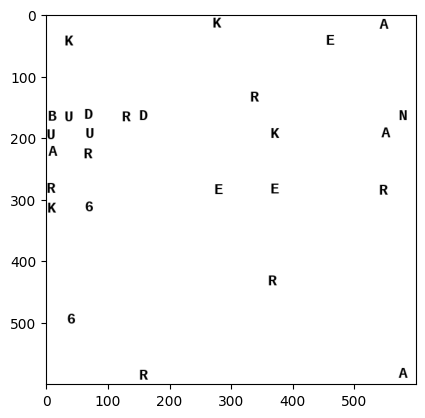

In [ ]:
# simplest case
ch = ['K', 'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
]
pos = [[0,9], [0,13], [4,13], [4, 9],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [10, 5], [7,7], [7,11], [10, 13 ], [13,11], [13,7],
]
img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
np.save('simplest', img)
np.save('simplestF', imgF)

# simple case
ch = ['K', 'A', 'R', 'E',
      'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      'U', 'A', 'R', 'K',
      'R', 'D',
      'K', '6', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
      ]
pos = [[0,9], [0,18], [9,18], [9, 9],
        [6, 18], [4, 11], [9, 12],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [6,0], [7,0], [9,0], [10,0],
        [5,4], [5,5],
        [6, 12], [10, 2], [14, 12] ]

# add slightly randomized 6KENAR
pos.append([np.random.randint(7, 17), 1]) #6
pos.append([1, np.random.randint(0, 6)]) #K
pos.append([1, np.random.randint(14, 20)]) #E
pos.append([np.random.randint(4, 8), 19]) #N
pos.append([np.random.randint(17, 20), 19]) #A
pos.append([19, np.random.randint(5, 13)]) #R

img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
plt.imshow(img)
np.save('simple', img)
np.save('simpleF', imgF)


# fixed font size cases
img50 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=50)
img100 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=100)
img150 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=150)
img250 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=250)
img400 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=400)
imgInsane = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=25, yCount=25, numLetters=3000)
np.save('test50', img50)
np.save('test100', img100)
np.save('test150', img150)
np.save('test250', img250)
np.save('test400', img400)
np.save('testInsane', imgInsane)

# variable font size cases
img50F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=50)
img100F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=100)
img150F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=150)
img250F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=250)
img400F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=400)
imgInsaneF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=25, yCount=25, numLetters=3000)
np.save('test50F', img50F)
np.save('test100F', img100F)
np.save('test150F', img150F)
np.save('test250F', img250F)
np.save('test400F', img400F)
np.save('testInsaneF', imgInsaneF)
#'''

Searching for KARE in simplest 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Found 1 KARE squares.
KARE in simplest: 1.194 sec.
Searching for BUDUR in simplest 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━

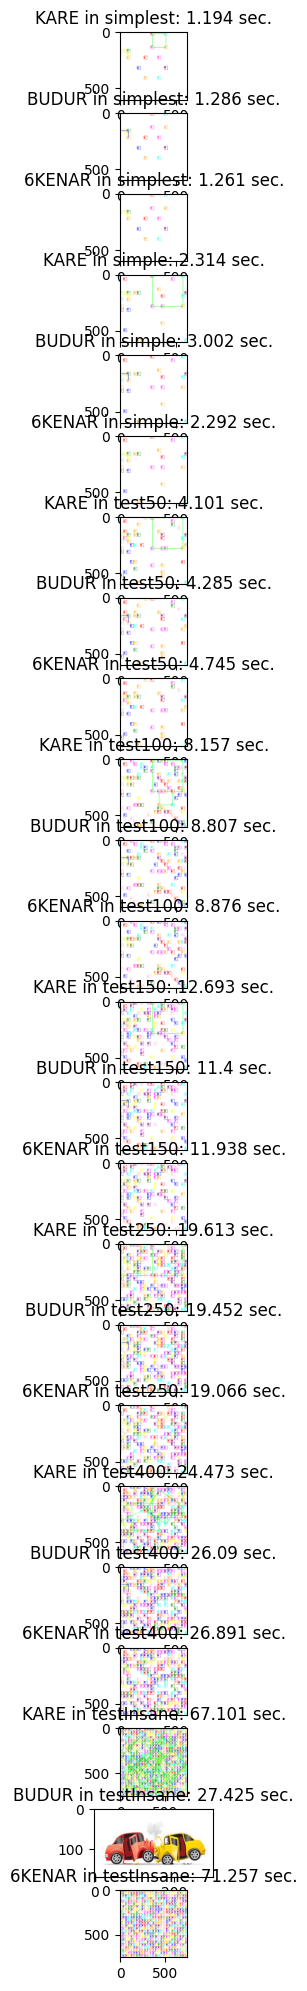

In [16]:
# fixed size font test
# if you trust your code, test them all togather
# or change the following to run one by one try it a few times you will get to the bottom of it
#PerformTest(test_basic)
PerformTest(test_all)

In [ ]:
# variable sized font tests
PerformTest(test_allF)